### "Компьютер говорит - Нет"

Эта работа итоговая работа по **Модулю 5** посвящена банковскому скорингу.

In [784]:
# pip install matplotlib

In [785]:
# pip install seaborn

In [786]:
# pip install scikit-learn

In [787]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import func_tools as ft

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [788]:
df1 = pd.read_csv('sf-dst-scoring/train.csv')
df2 = pd.read_csv('sf-dst-scoring/test.csv')

In [789]:
df1['flag'] = 1
df2['flag'] = 0

In [790]:
df = pd.concat([df1,df2],axis=0)

In [791]:
df.shape

(110148, 20)

In [792]:
ft.DESCR()

,описание данных
client_id,идентификатор клиента
education,уровень образования
sex,пол заёмщика
age,возраст заёмщика
car,флаг наличия автомобиля
car_type,флаг автомобиля-иномарки
decline_app_cnt,количество отказанных прошлых заявок
good_work,флаг наличия «хорошей» работы
bki_request_cnt,количество запросов в БКИ
home_address,категоризатор домашнего адреса


In [793]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

In [794]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
flag                    0
dtype: int64

In [795]:
df.describe(include='object')

,app_date,education,sex,car,car_type,foreign_passport
count,110148,109670,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,57998,61836,74290,89140,93721


In [796]:
df.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

In [797]:
df.education.fillna('SCH',inplace=True)

In [798]:
df['education_range'] = df.education
edu_dict = {'SCH':0, 'UGR':1, 'GRD':2, 'PGR':3, 'ACD':4}
for level in edu_dict:
    df.education_range.replace(level, edu_dict[level], inplace=True)

In [799]:
df.education_range.unique()

array([0, 2, 1, 3, 4])

In [800]:
df['day'] = df.app_date.apply(lambda x: int(x[0:2]))
df['month'] = df.app_date.apply(lambda x: x[2:5])
df['year'] = df.app_date.apply(lambda x: x[5:])

In [801]:
df.month.unique()

array(['FEB', 'MAR', 'JAN', 'APR'], dtype=object)

In [802]:
month_dict = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10,'NOV':11,'DEC':12}
for mon in month_dict:
    df.month.replace(mon, month_dict[mon], inplace=True)

In [803]:
df['date_time'] = pd.to_datetime(df[['day','month','year']])

df['days_from_start'] = (df.date_time - df.date_time.min()).apply(lambda x: x.days)

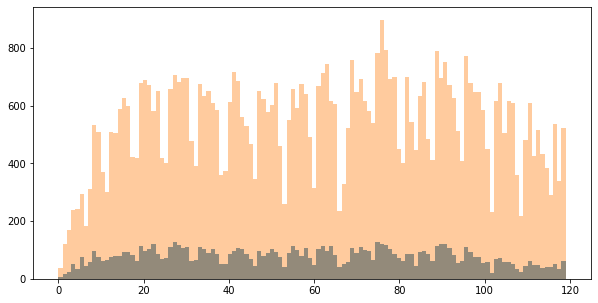

In [804]:
fig = plt.figure(figsize=(10,5))
plt.hist(df.query('default==1').days_from_start, bins=df.days_from_start.nunique(), alpha=0.8);
plt.hist(df.query('default==0').days_from_start, bins=df.days_from_start.nunique(), alpha=0.4);

In [805]:
df.drop(columns=['app_date','education'],inplace=True)

In [806]:
df.first_time.unique()

array([1, 4, 3, 2])

In [807]:
df.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,first_time,foreign_passport,default,flag,education_range,day,month,year,date_time,days_from_start
0,25905,M,62,Y,Y,0,0,-2.008753,1,50,...,1,N,0.0,1,0,1,2,2014,2014-02-01,31
1,63161,F,59,N,N,0,0,-1.532276,3,50,...,1,N,0.0,1,0,12,3,2014,2014-03-12,70
2,25887,M,25,Y,N,2,0,-1.408142,1,80,...,4,Y,0.0,1,0,1,2,2014,2014-02-01,31
3,16222,F,53,N,N,0,0,-2.057471,2,50,...,3,N,0.0,1,0,23,1,2014,2014-01-23,22
4,101655,M,48,N,N,0,1,-1.244723,1,60,...,4,Y,0.0,1,2,18,4,2014,2014-04-18,107


In [808]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   sex               110148 non-null  object        
 2   age               110148 non-null  int64         
 3   car               110148 non-null  object        
 4   car_type          110148 non-null  object        
 5   decline_app_cnt   110148 non-null  int64         
 6   good_work         110148 non-null  int64         
 7   score_bki         110148 non-null  float64       
 8   bki_request_cnt   110148 non-null  int64         
 9   region_rating     110148 non-null  int64         
 10  home_address      110148 non-null  int64         
 11  work_address      110148 non-null  int64         
 12  income            110148 non-null  int64         
 13  sna               110148 non-null  int64         
 14  first

In [809]:
cat_cols = ['home_address','client_id','education_range','work_address']
bin_cols = ['sex','car','car_type','good_work','foreign_passport']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt',
            'region_rating','income','first_time', 'day','month', 'days_from_start','sna']


          Графики для "age"                                  Графики для log("age"+1)/n


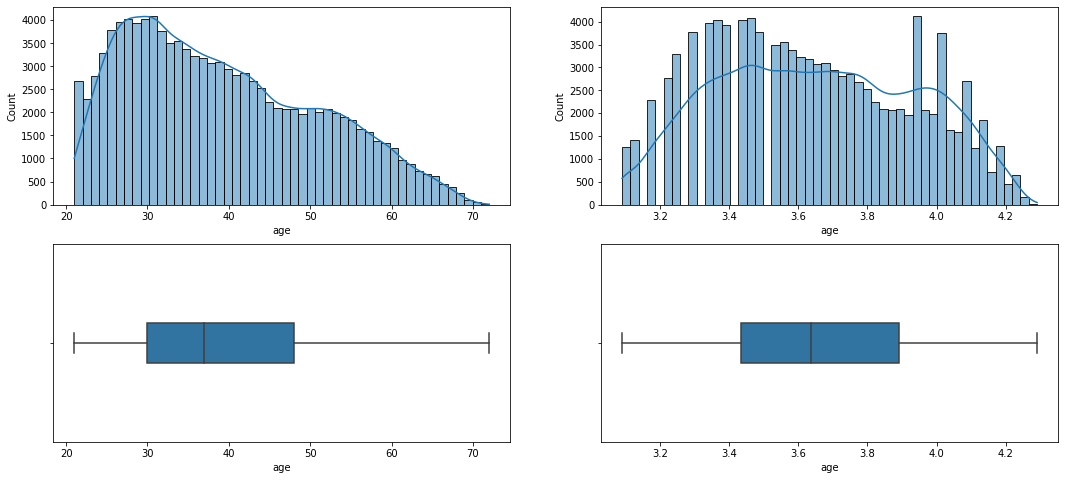


          Графики для "decline_app_cnt"                                  Графики для log("decline_app_cnt"+1)/n


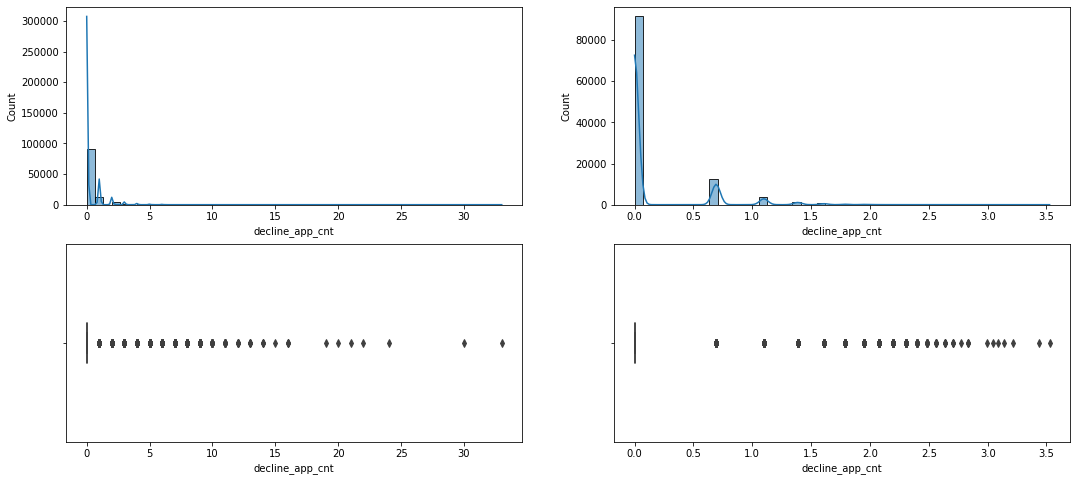


          Графики для "score_bki"                                  Графики для log("score_bki"+1)/n


/home/alenazarodnyuk/.conda/envs/myenv/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alenazarodnyuk/.conda/envs/myenv/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


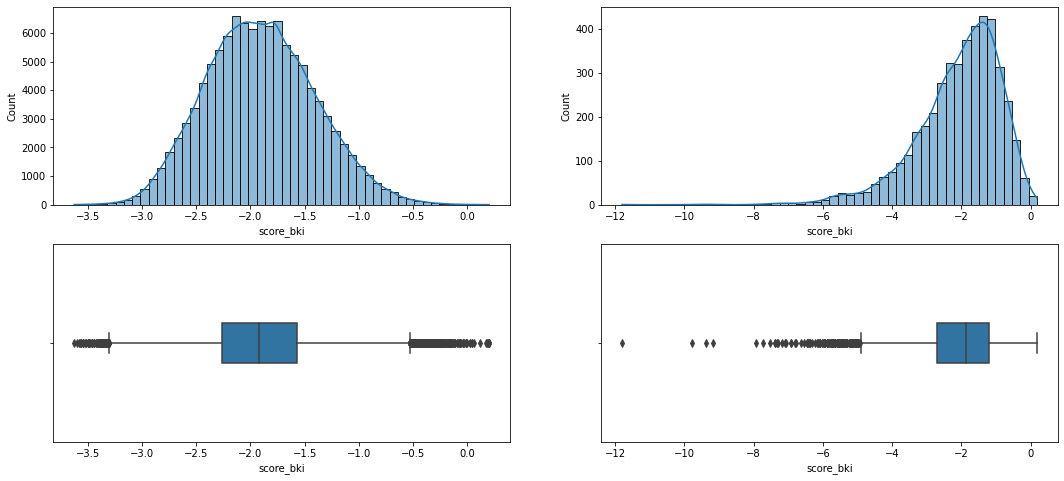


          Графики для "bki_request_cnt"                                  Графики для log("bki_request_cnt"+1)/n


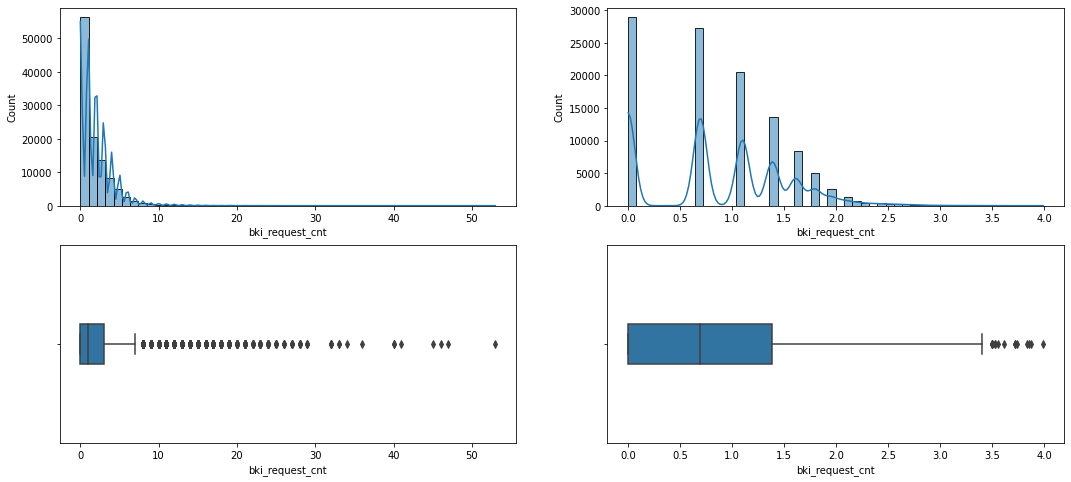


          Графики для "region_rating"                                  Графики для log("region_rating"+1)/n


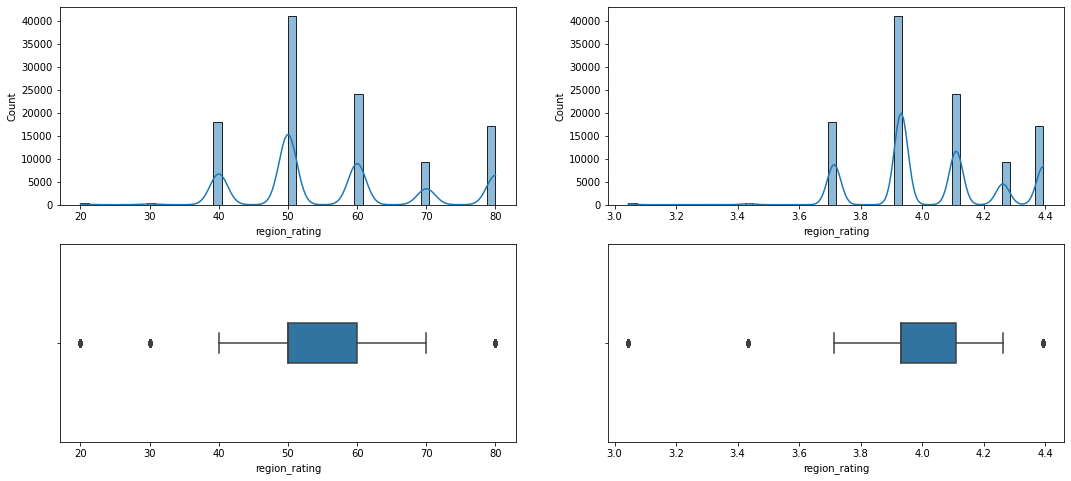


          Графики для "income"                                  Графики для log("income"+1)/n


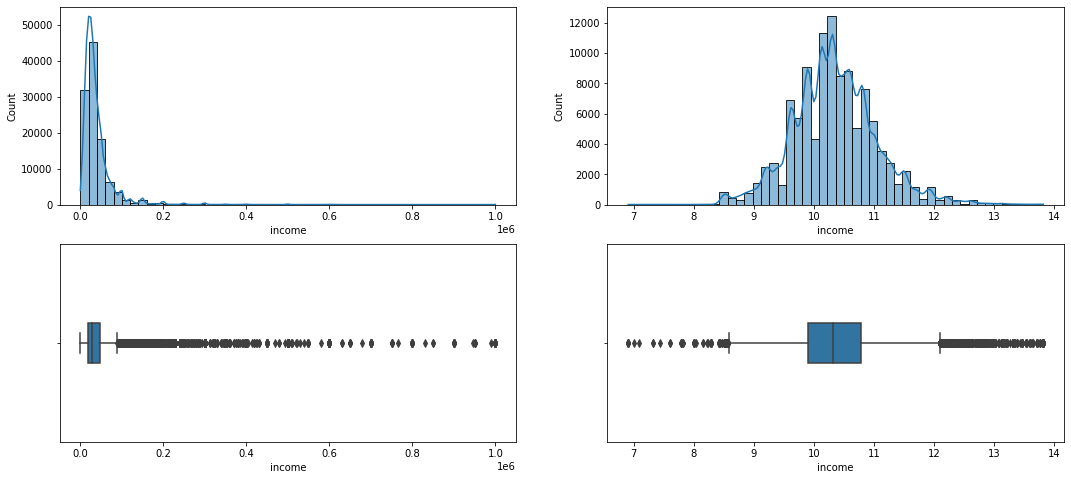


          Графики для "first_time"                                  Графики для log("first_time"+1)/n


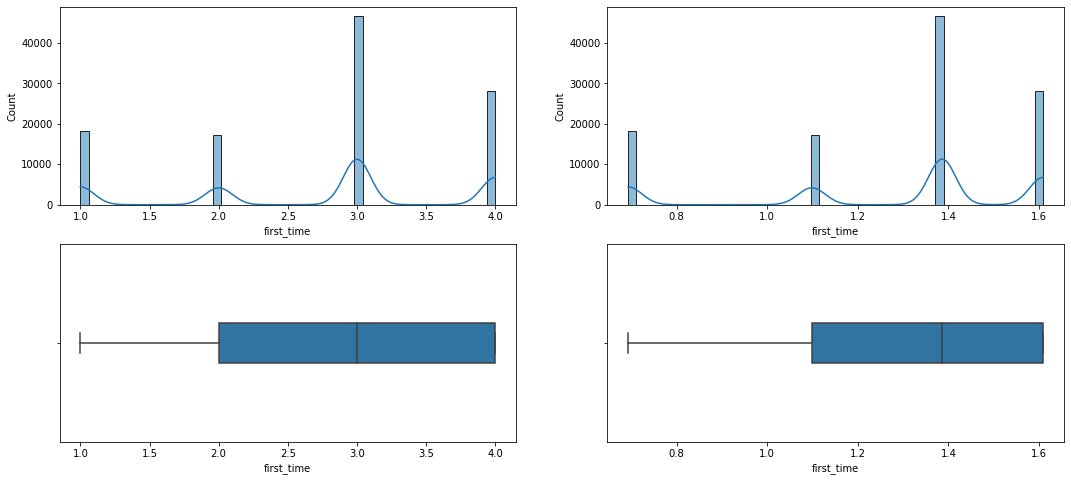


          Графики для "day"                                  Графики для log("day"+1)/n


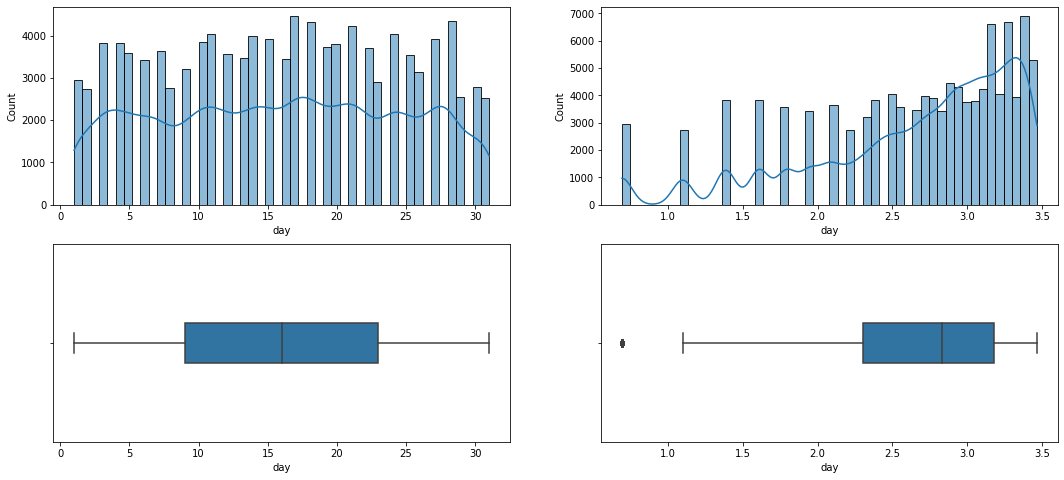


          Графики для "month"                                  Графики для log("month"+1)/n


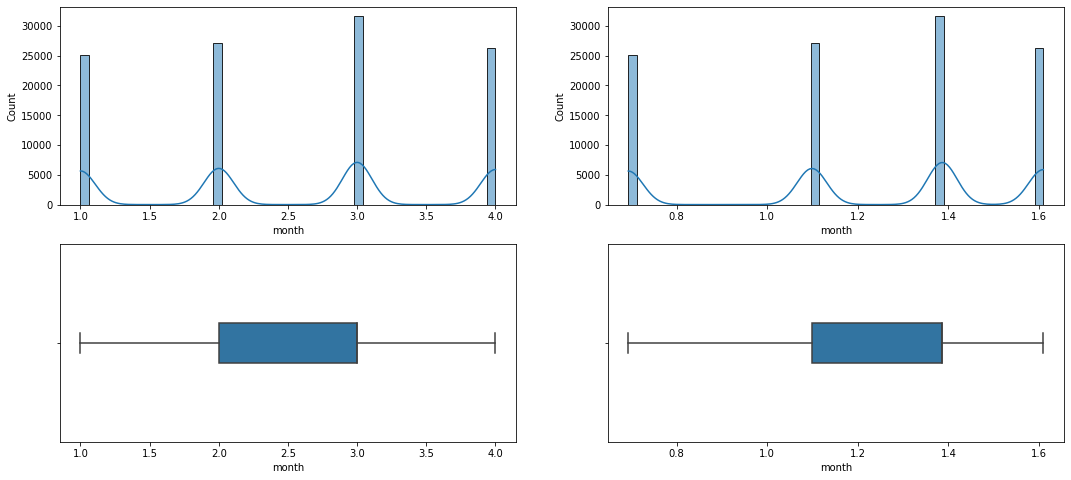


          Графики для "days_from_start"                                  Графики для log("days_from_start"+1)/n


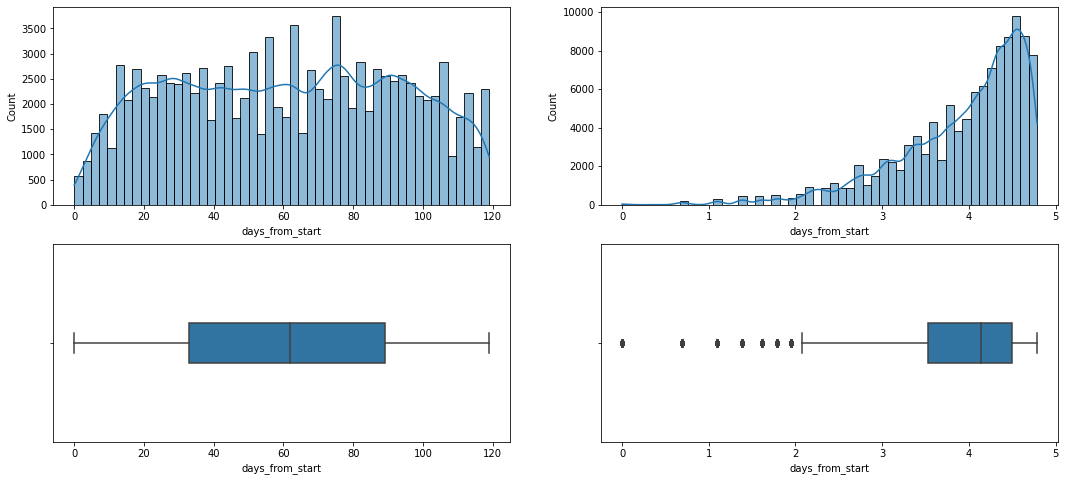


          Графики для "sna"                                  Графики для log("sna"+1)/n


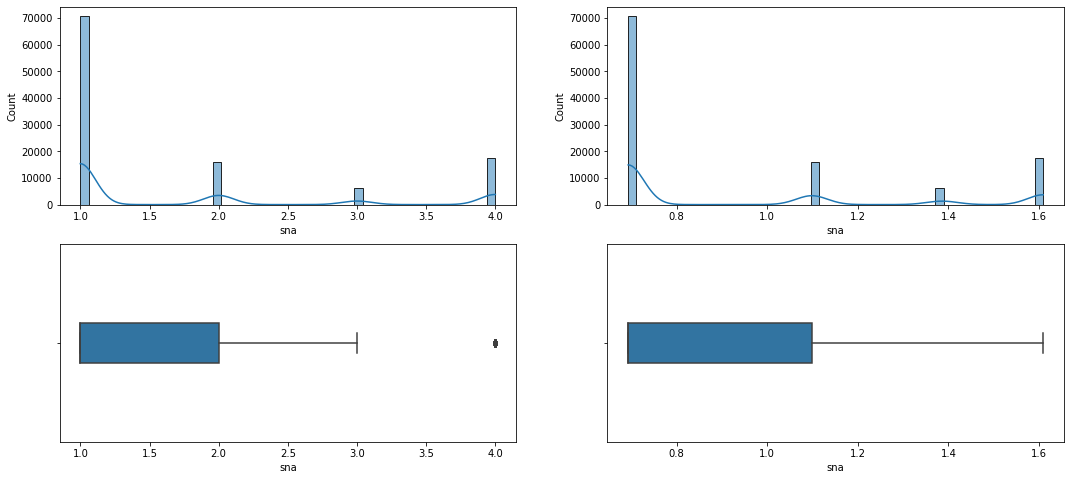

In [810]:
for column in num_cols:
    print(f'\n          Графики для "{column}"                                  Графики для log("{column}"+1)/n')
    ft.make_hist_and_box(df,column)

Получаем, что у колонок ['age','decline_app_cnt', 'bki_request_cnt', 'income','day','days_from_start] распределение не нормальное, и применив логарифм, можно его свести к нормальному.

Для этих колонок ['score_bki','first_time','region_rating','app_month','first_time','month','sna'] манипуляции с логарифмированием ничего не  дают.

Построим диаграмму для переменной default. (Каких клиентов у банка больше?)

#### Рассмотрим диаграммы для категориальных признаков

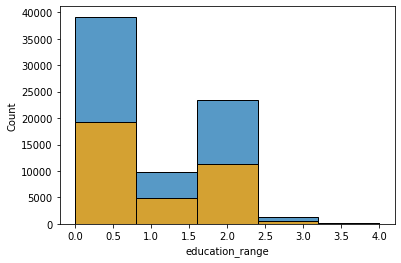

In [811]:
ft.compare_dist(df, 'education_range')

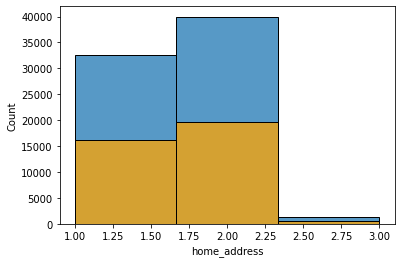

In [812]:
ft.compare_dist(df, 'home_address')

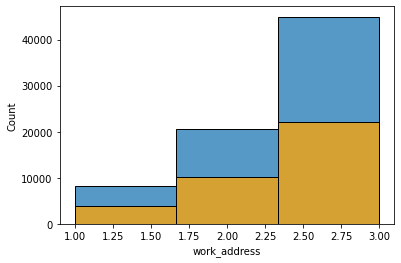

In [813]:
ft.compare_dist(df, 'work_address')

Видим, что особой зависимости от уровня образования, адресов работы и дома у дефолта нет.

#### Рассмотрим кореляции признаков

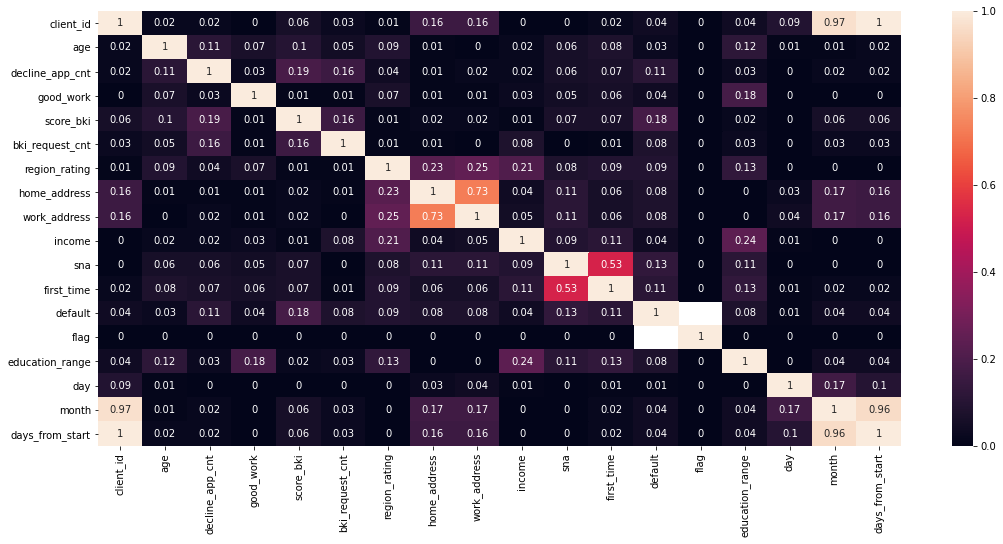

In [814]:
fig = plt.figure(figsize=(18,8))
sns.heatmap(abs(df.corr()).round(2),annot=True);

Видим большие коэффициенты корреляции между некоторыми столбцами. Удалим некоторые из них.

In [815]:
col_to_drop = ['client_id', 'month']

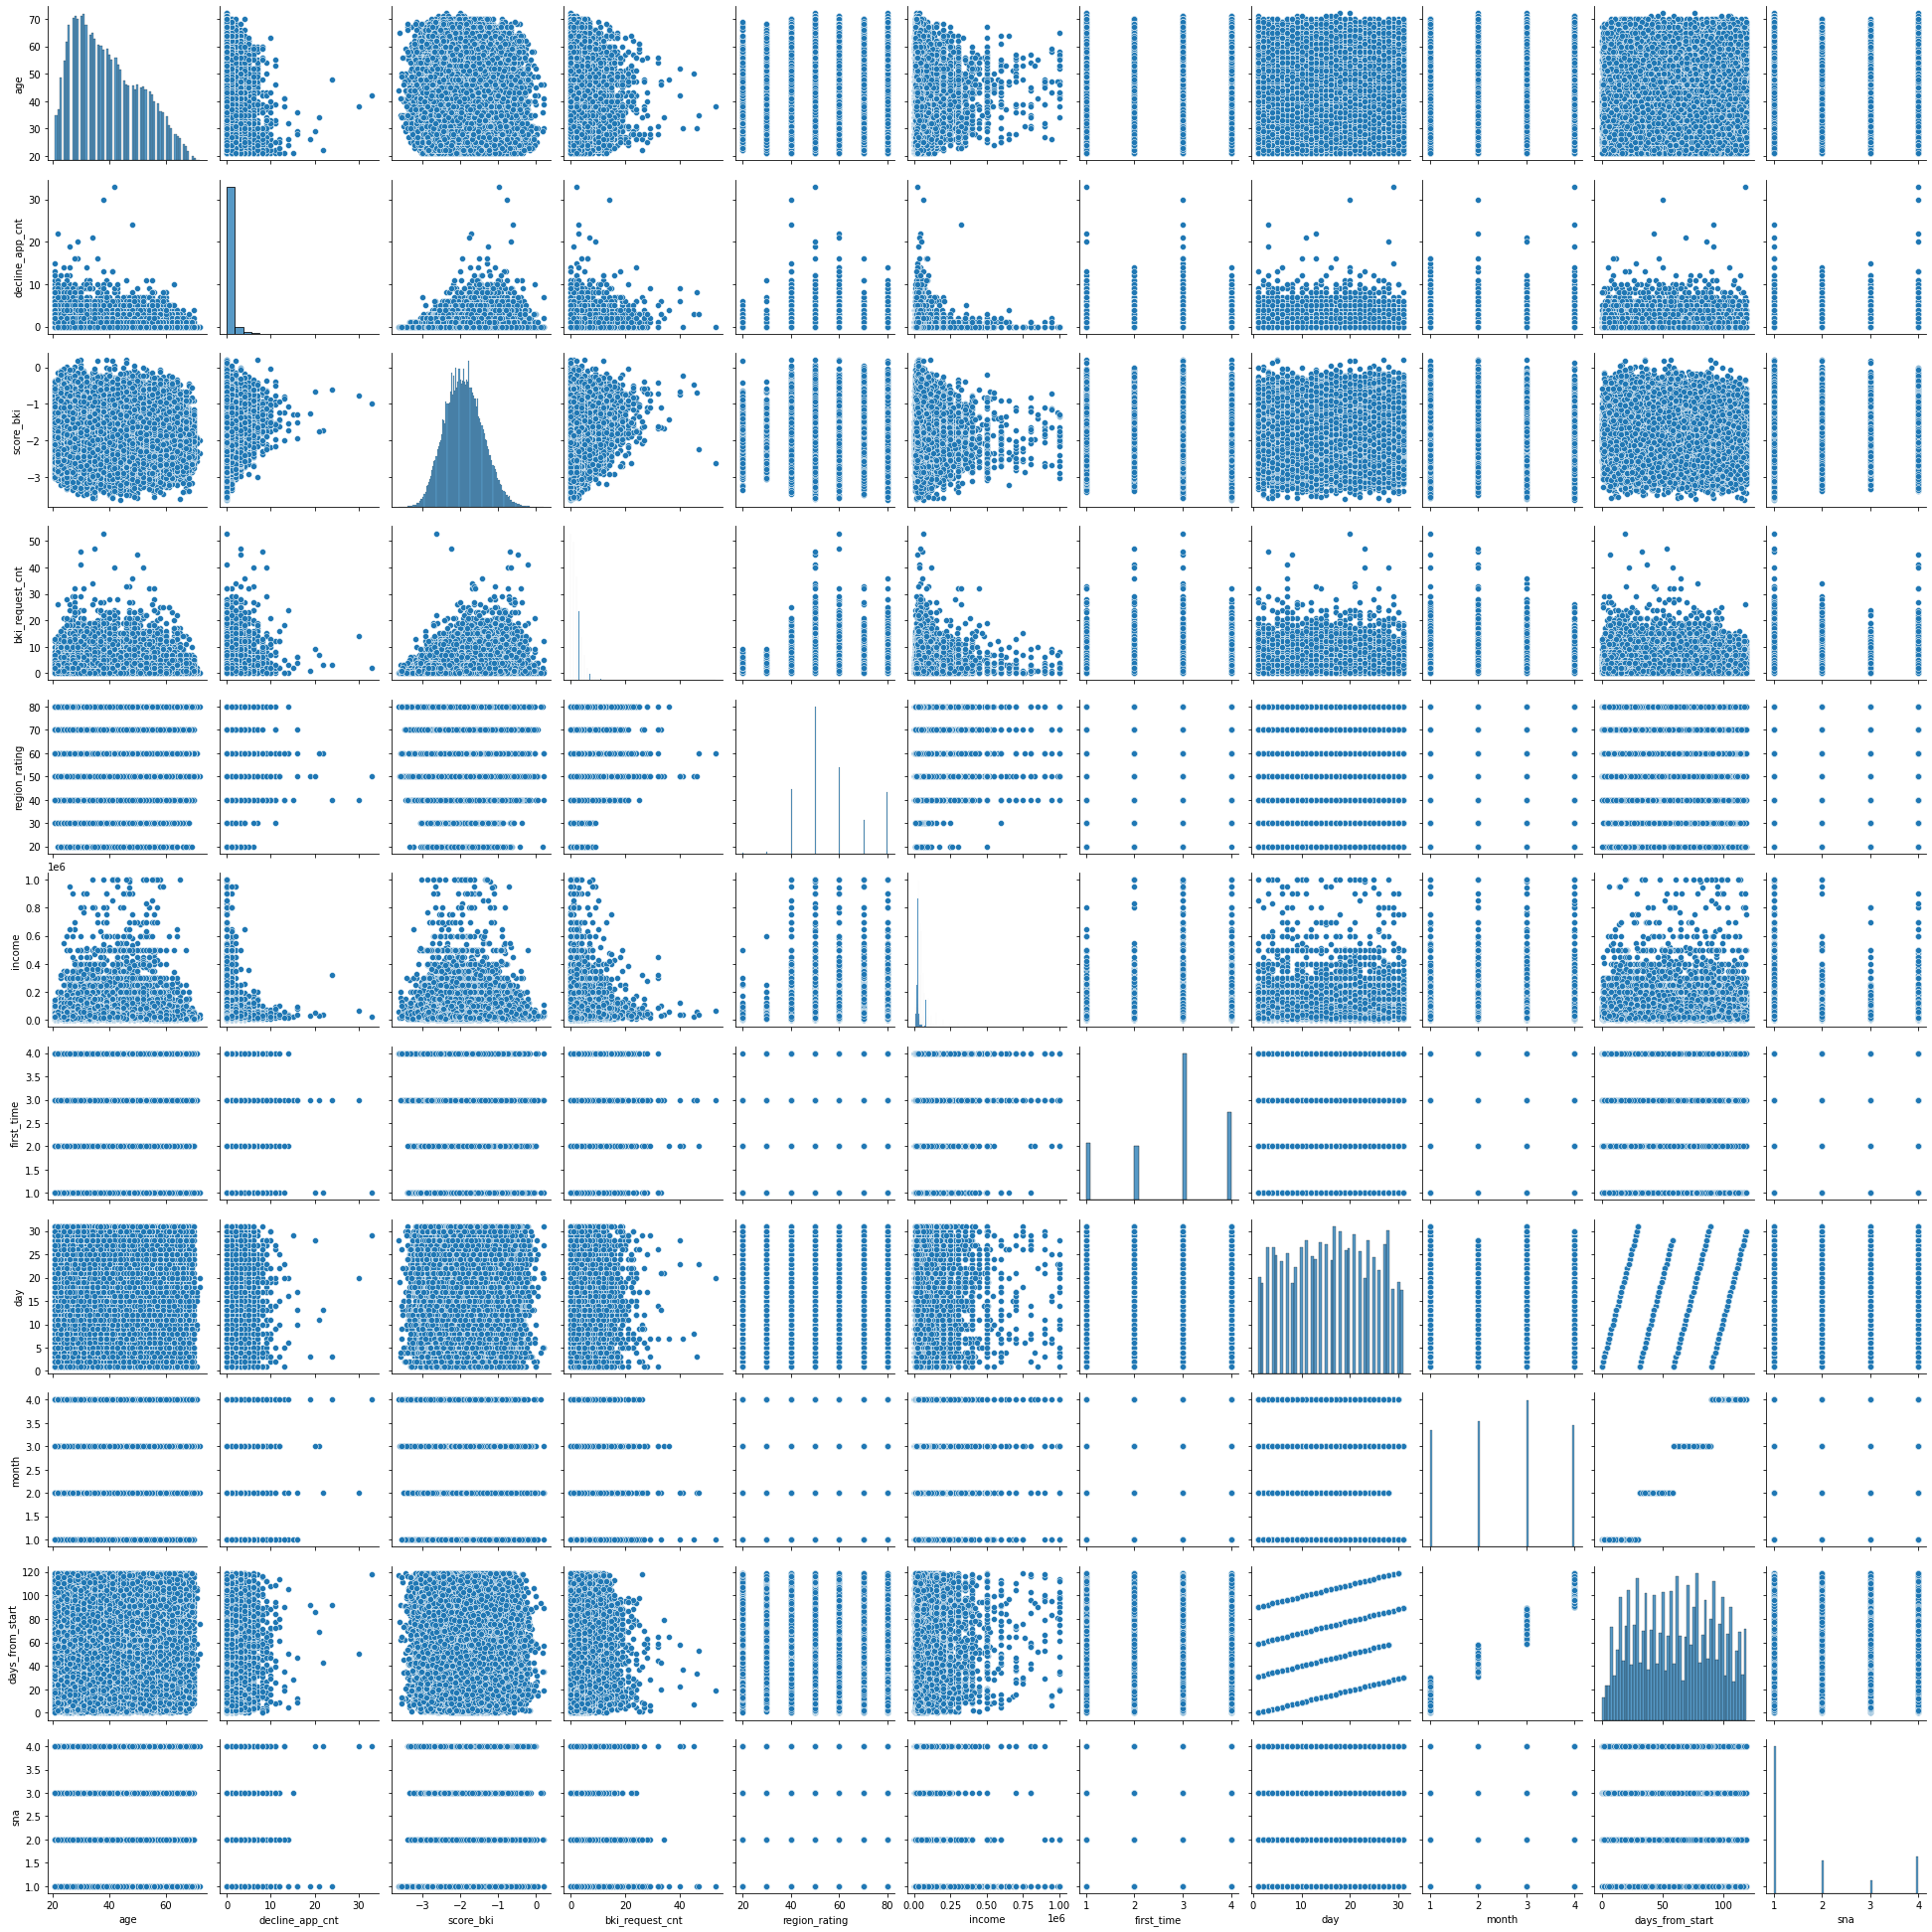

In [1099]:
sns.pairplot(df[num_cols])

#### Значимость непрерывных переменных

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

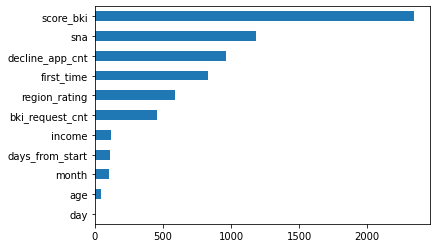

In [816]:
imp_num = pd.Series(f_classif(df[df['flag']==1][num_cols], df[df['flag']==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Столбец "day" оказался малозначимым.

In [817]:
col_to_drop+=['day']

#### Категориальные переменные

Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле sex значение *sex = female* преобразовать в , а *sex = male* — в . Эту простую операцию приходится делать достаточно часто, поэтому в модуле **sklearn.preprocessing** именно для этой задачи реализован класс **LabelEncoder**.

Метод **fit** этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод **transform** непосредственно преобразует значения в числа. После **fit** у **label_encoder** будет доступно поле **classes_**, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [818]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [819]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,first_time,foreign_passport,default,flag,education_range,day,month,year,date_time,days_from_start
0,25905,1,62,1,1,0,0,-2.008753,1,50,...,1,0,0.0,1,0,1,2,2014,2014-02-01,31
1,63161,0,59,0,0,0,0,-1.532276,3,50,...,1,0,0.0,1,0,12,3,2014,2014-03-12,70
2,25887,1,25,1,0,2,0,-1.408142,1,80,...,4,1,0.0,1,0,1,2,2014,2014-02-01,31
3,16222,0,53,0,0,0,0,-2.057471,2,50,...,3,0,0.0,1,0,23,1,2014,2014-01-23,22
4,101655,1,48,0,0,0,1,-1.244723,1,60,...,4,1,0.0,1,2,18,4,2014,2014-04-18,107


#### ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

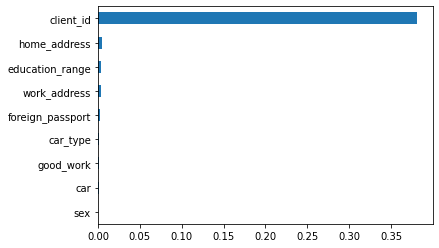

In [820]:
# категориальные признаки

imp_cat = pd.Series(mutual_info_classif(df[df['flag']==1][bin_cols + cat_cols], df[df['flag']==1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Удалим неважные признаки:

In [821]:
col_to_drop+=['sex','car','good_work', 'car_type']

In [822]:
# df.drop(columns=col_to_drop, inplace=True)

#### Подготовка данных к машинному обучению

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

Как вы уже поняли, LabelEncoder не совсем подходит для признаков с двумя и большим количеством категорий. Для того, чтобы мы смогли применять линейные модели на таких данных, нам необходим другой метод, который называется **One-Hot Encoding**. Смысл его точно такой же, как у dummy-кодирования.

Предположим, что некоторый признак может принимать пять разных значений. В этом случае One Hot Encoding подразумевает создание пяти новых признаков, все из которых равны нулю, за исключением одного. На позицию, соответствующую численному значению признака, мы помещаем .

Эта техника реализована в **sklearn.preprocessing** в классе **OneHotEncoder**. По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей.

In [823]:
cat_cols

['home_address', 'client_id', 'education_range', 'work_address']

In [824]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[['home_address', 
                                                       'work_address']].values)

In [1081]:
X_log = np.log(df[['age','decline_app_cnt', 'bki_request_cnt', 'income','day','days_from_start']]+1)

In [1082]:
X_num = df[['score_bki','first_time','region_rating','first_time','month','sna','client_id']].to_numpy()

In [1083]:
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [1084]:
X_bin = df[bin_cols].to_numpy()

In [1085]:
X_cat.shape

(110148, 6)

In [1086]:
# Стандартизация числовых переменных

scaler = sklearn.preprocessing.StandardScaler()

X_num = scaler.fit_transform(X_num)
X_log = scaler.fit_transform(X_log)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [1087]:
X_num.shape

(110148, 7)

In [1088]:
X_log.shape

(110148, 6)

In [1089]:
train_index = list(df[df['flag']==1].index)

In [1090]:
# Объединяем

X_big = np.hstack([X_num, X_log, X_bin, X_cat])
Y_big = df['default'].values

In [1091]:
X = X_big[train_index,:]
Y = Y_big[train_index]

Разделим данные для обучения следующим образом:

In [1092]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [1093]:
logreg = LogisticRegression(C=1,solver = 'liblinear',max_iter=1000)

In [1094]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

#### Оценка качества модели

В качестве методов оценки прогностической способности модели вы решаете использовать ROC-анализ.

Вы прекрасно помните из модуля по Классификации, что классификатор имеет параметр порог отсечения. Изменяя его значение, мы получаем то или иное разбиение на два класса — класс с положительными исходами и класс с отрицательными исходами.

**В нашем примере положительным исходом будет наличие дефолта у заемщика, отрицательным — отсутствие дефолта.**

Доля положительных результатов у «плохих» заемщиков (истинно положительных результатов) — это чувствительность модели (Sensitivity), то есть способность модели правильно определять «плохих» заемщиков и минимизировать убытки, связанные с выдачей кредита «плохому» клиенту. 

Доля отрицательных результатов у «хороших» заемщиков (истинно отрицательных результатов) — это специфичность модели (Specificity). Здесь речь уже идёт о способности модели правильно определять «хороших» заемщиков и минимизировать убытки, связанные с отказом в выдаче кредита добросовестному клиенту. 

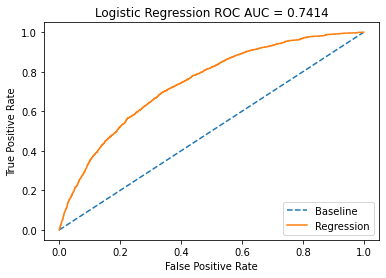

In [1095]:
probs = logreg.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [1050]:
pred = logreg.predict(X_test)

 ### !!!!!!
 Отказ в кредите хорошему заемщику — **ошибка первого рода**. (01 - FP)
 
 Дать кредит заёмщику, который впоследствии может допустить дефолт — **ошибка второго рода.**  (10 - FN)

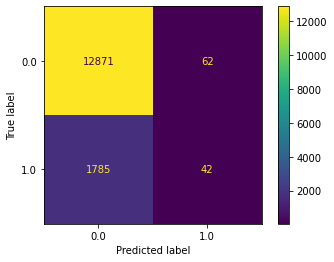

In [1051]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg,X_test,y_test);

#### СОВЕТ НЕИЗВЕСТНОГО: РЕГУЛЯРИЗАЦИЯ

Гиперпараметры — это внешние параметры для классификатора, которые не могут быть изучены самим классификатором и чаще всего задаются вручную. Логистическая регрессия, например, не способна сама выучить наилучшее значение для, например, параметра С.  В scikit-learn они передаются в качестве аргументов конструктору класса. Найдя оптимальные параметры, мы можем улучшить предсказательную силу нашей логистической регрессии.

In [842]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=2)
# skf.get_n_splits(X, Y)

# print(skf)
# StratifiedKFold(n_splits=2, random_state=42, shuffle=False)
# for train_index, test_index in skf.split(X, Y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]

In [843]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1']
solver = ['saga']

# Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 10, 40)

# Создадим гиперпараметры
# hyperparameters = dict(C=C,solver=solver, penalty=penalty)

hyperparameters = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'C': np.logspace(0, 40, 10)},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'C': np.logspace(0, 40, 10)},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'C': np.logspace(0, 40, 10)},
]

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, n_jobs=-1)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее solver: newton-cg
Лучшее C: 27825.59402207126


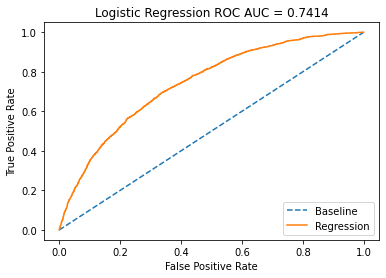

In [986]:
logreg = LogisticRegression(C=best_model.best_estimator_.get_params()['C'],
                            solver = best_model.best_estimator_.get_params()['solver'],
                            max_iter=1000)
logreg.fit(X_train,y_train)

probs = logreg.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [987]:
# test_index = list(df[df.default.isna()].index)

In [988]:
df1.shape

(73799, 20)

In [989]:
default = logreg.predict_proba(X_big[73799:,:])[:,1]

In [990]:
submission = df.iloc[73799:][['client_id', 'default']]
submission['default'] = pd.Series(default)

In [991]:
# submission.to_csv('submission.csv',index=False)

In [992]:
submission

,client_id,default
0,74835,0.050848
1,17527,0.358893
2,75683,0.058759
3,26883,0.094544
4,28862,0.034168
...,...,...
36344,83775,0.329097
36345,106254,0.020295
36346,81852,0.365119
36347,1971,0.216729


In [993]:
submission.query('client_id==74835')

,client_id,default
0,74835,0.050848


In [929]:
len(test_index)

36349

In [960]:
X_big[73799:,:].shape

(36349, 24)